In [2]:
%matplotlib inline
import networkx as nx
import metis
import pandas as pd
from scipy.stats import pearsonr
from collections import defaultdict
from datetime import timedelta, datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

from rwc import controversy_score
from util import tw_list, get_cut_ratio
from leopard import update_partition



In [3]:
retweets = pd.read_pickle('data/july.pkl')

In [4]:
retweets.sort_values(by=['created_at'], axis='index', inplace=True)

In [5]:
DEBUG = False
incremental = True
update_interval = timedelta(minutes=5)
T_window = timedelta(minutes=60)
top_node_percent=0.01


In [6]:
# prevent pickling error in multiprocessing
def defaultdict_using_list_func(): 
    return defaultdict(list)

def earlist_date_func(): 
    return datetime(1970, 1, 1)

In [7]:
def run_simulation(update_interval, T_window, top_node_percent, incremental,
                   return_log=False,
                   return_graph=False):
    """
    update_interval: graph stat update interval
    T_window: time window 
    top_node_percent: the number of nodes to consider for RWC calculation
    incremental: incremental1 computation or not
    
    Returns:
    
    tag2log: logging for update on each tag
    running_stat: running statistics
    top_hashtags_by_time: top hashtags at different times
    tag2g: hashtag to graph
    """
    running_stat = {
        'start_time': datetime.now(),
        'update_interval': update_interval, 
        'T_window': T_window,
        'incremental': incremental
    }
    # logging for tags
    tag2log = defaultdict(defaultdict_using_list_func)
    
    # internal data structures
    tag2g = defaultdict(nx.Graph)
    tag2edge_list = defaultdict(tw_list)
    tag2edges_rm = defaultdict(list)
    tag2edges_add = defaultdict(list)
    
    top_hashtags_by_time = []  # TODO: top hashtags at different time points

    last_updated_time = defaultdict(earlist_date_func)

    for i, rt in tqdm(retweets.head(int(1e5)).iterrows()):
        if i % 5000 == 0:
            # print('#hashtags {}'.format(len(tag2g)))
            # print('now {}'.format(rt['created_at']))
            pass

        h = rt['hashtag']
        g = tag2g[h]  
        edge_list = tag2edge_list[h]

        u, v, now = rt['retweeter'], rt['retweetee'], rt['created_at']

        tag2edges_add[h].append((u, v))

        # remove expired edges by triggered hashtag or do it periodically?
        earlist_time = now - T_window
        edges_to_remove = edge_list.remove_before_time(earlist_time)
        if edges_to_remove:
            tag2edges_rm[h] += edges_to_remove

        last_updated_time = g.graph.get('last_updated_time')

        if last_updated_time is None or now - last_updated_time > update_interval:
#             def print_log():
#                 print('calculating {}'.format(h))
#                 print('add {} edges'.format(len(edges_to_add)))
#                 print('rm {} edges'.format(len(edges_to_rm)))                

            # when the graph is processed for the 1st time 
            # and it's very small, it will not be updated
            updated = False

            # update
            edges_to_add = tag2edges_add[h]
            edges_to_rm = tag2edges_rm[h]

            # empty it
            tag2edges_add[h] = []
            tag2edges_rm[h] = []

            pr_vects = g.graph.get('pagerank_vectors')
            if not pr_vects or not incremental:  # 1st time                    
                g.add_edges_from(edges_to_add)
                g.remove_edges_from(edges_to_rm)
                if g.number_of_nodes() > 100:  # only calculate RWC when the graph is big enough
                    if DEBUG:
                        # print_log()
                        pass
                    cuts, node_cluster_ids = metis.part_graph(g, 2)
                    rwc, aux = controversy_score(g, node_cluster_ids, top_percent=top_node_percent)
                    updated = True
            else:  # incremental
                if DEBUG:
                    print('updating')
                    # print_log()
                node_cluster_ids = g.graph['node_cluster_ids']
                node_cluster_ids = update_partition(g, node_cluster_ids,
                                                    edges_to_add=edges_to_add,
                                                    edges_to_remove=edges_to_rm,                                                         
                                                    verbose=False)
                pr0 = {n: pr_vects['pr0'].get(n, 0) for n in g.nodes_iter()}
                pr1 = {n: pr_vects['pr1'].get(n, 0) for n in g.nodes_iter()}
                rwc, aux = controversy_score(g, node_cluster_ids,
                                             top_percent=top_node_percent,
                                             nstart0=pr0,
                                             nstart1=pr1)
                updated = True

            if updated:                    
                g.graph['node_cluster_ids'] = node_cluster_ids
                g.graph['pagerank_vectors'] = {'pr0': aux['pr0'], 'pr1': aux['pr1']}
                g.graph['rwc'] = rwc
                g.graph['last_updated_time'] = now  # TODO: now should be changed            

                tag2log[h]['rwc'].append(rwc)
                tag2log[h]['graph_size'].append(g.number_of_nodes())
                tag2log[h]['cut_ratio'].append(get_cut_ratio(g, node_cluster_ids))
                tag2log[h]['updated_time'].append(now)



        # filter out non-controversial hashtags

        # top-k hashtag update
    running_stat['end_time'] = datetime.now()
    to_return = (running_stat, top_hashtags_by_time)
    if return_log:
        to_return += (tag2log, )
    if return_graph:
        to_return += (tag2g, )
    return to_return

In [ ]:
# some test
result = run_simulation(T_window=T_window,
                        top_node_percent=top_node_percent,
                        update_interval=update_interval,
                        incremental=False)
print((result[1]['end_time'] - result[1]['start_time']).seconds)

In [ ]:
# update interval vs running time on (incremental, from-scratch)
update_intervals = [timedelta(minutes=i) for i in [4, 8, 16, 32]]
T_window = timedelta(minutes=60)

results = Parallel(n_jobs=8)(delayed(run_simulation)(update_interval=update_interval,
                                                     T_window=T_window,
                                                     top_node_percent=top_node_percent,
                                                     incremental=incremental)
                             for incremental in [True, False]
                             for update_interval in update_intervals)


In [ ]:
df = pd.DataFrame.from_records([r[0] for r in results])
df['seconds'] = (df['end_time'] - df['start_time']).apply(lambda t: t.seconds)
df['update_interval'] = df['update_interval'].apply(lambda i: i.seconds/60)
df['throughput'] = 1e5 / df['seconds']
df

In [ ]:
leopard = df[df['incremental'] == True]
metis = df[df['incremental'] == False]

plt.plot(leopard['update_interval'], leopard['throughput'], '-o')
plt.plot(metis['update_interval'], metis['throughput'], '-*')
plt.legend(['Incremental', 'From scratch'], loc='upper left')
plt.xlabel('Update interval (minutes)')
plt.ylabel('Throughput (#tweets / second)')
plt.ylim([100, 1400])
plt.title('Throughput vs update interval')
plt.savefig('figs/throughput_comparison.pdf')

In [8]:
# controversy score on incremental and non-incremental
update_intervals = [timedelta(minutes=i) for i in [5, 10, 15, 20, 25]]
T_window = timedelta(minutes=60)

results = Parallel(n_jobs=8)(delayed(run_simulation)(update_interval=update_interval,
                                                     T_window=T_window,
                                                     top_node_percent=top_node_percent,
                                                     incremental=incremental,
                                                     return_log=True)
                             for incremental in [True, False]
                             for update_interval in update_intervals)


100000it [01:27, 1136.98it/s]
100000it [01:37, 1024.71it/s]
100000it [01:51, 894.90it/s]
100000it [02:19, 715.40it/s]
100000it [02:52, 367.69it/s]
100000it [03:21, 496.42it/s]
100000it [02:00, 828.98it/s]
100000it [02:20, 709.46it/s]
100000it [03:53, 428.84it/s]
100000it [06:24, 260.23it/s]


In [17]:
key1, key2 = 'incremental', 'update_interval'
rows = defaultdict(list)
hashtags = list(results[0][2].keys())
for r in results:
    params, log = r[0], r[2]
    for h in hashtags:
        rows[(params[key1], params[key2])] += log[h]['rwc']
incs, upds = zip(*list(rows.keys()))
rwcs = list(rows.values())
df = pd.DataFrame.from_dict({'incremental': incs, 
                             'update_interval': upds, 
                             'rwcs':rwcs})

(4.0, 26.0)

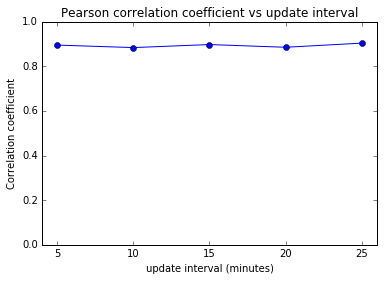

In [49]:
pcr = df.groupby('update_interval').apply(lambda sdf: pearsonr(*sdf['rwcs'])[0])
minutes = pcr.index.map(lambda m: m.seconds/60)
corrs = pcr.values
plt.plot(minutes, corrs, '-o')
plt.xlabel('update interval (minutes)')
plt.ylabel('Correlation coefficient')
plt.title('Pearson correlation coefficient vs update interval')
plt.ylim([0, 1.0])
plt.xlim([min(minutes) - 1, max(minutes) + 1])

In [58]:
r1 = df[(df['incremental'] == True) & (df['update_interval'] == timedelta(minutes=25))].iloc[0]['rwcs']
r2 = df[(df['incremental'] == False) & (df['update_interval'] == timedelta(minutes=25))].iloc[0]['rwcs']

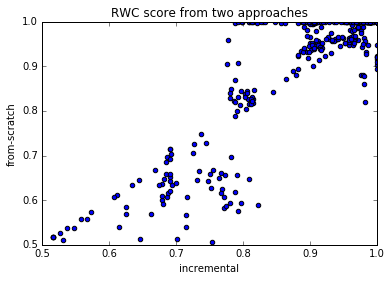

In [60]:
plt.scatter(r1, r2)
plt.xlim([0.5, 1.0])
plt.ylim([0.5, 1.0])
plt.xlabel('incremental')
plt.ylabel('from-scratch')
plt.title('RWC score from two approaches')

In [ ]:
tag2log, running_stat, top_hashtags_by_time, tag2g = ()
hottest_h = max(tag2g, key=lambda k: tag2g[k].number_of_nodes())

In [ ]:
g = tag2g[hottest_h]
log = tag2log[hottest_h]

In [ ]:
df = pd.DataFrame.from_dict(log)

In [ ]:
df.plot(x='time', y='rwc', ylim=[0.5, 1])

In [ ]:
df.plot(x='time', y='graph_size')

In [ ]:
df.plot(x='time', y='cut_ratio')